<a href="https://colab.research.google.com/github/usermar445/aml_final_project/blob/main/scripts/aml_higgs_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


# Load data

In [5]:
df_tree = pd.read_csv("/content/drive/MyDrive/aml/data/covtype_train.csv")
df_higgs = pd.read_csv("/content/drive/MyDrive/aml/data/higgs_train.csv")
df_heloc = pd.read_csv("/content/drive/MyDrive/aml/data/heloc_train.csv")

# Higgs data

In [17]:
# drop EventId column -> just some Id we dont need
higgs = df_higgs.drop(['EventId'], axis=1)

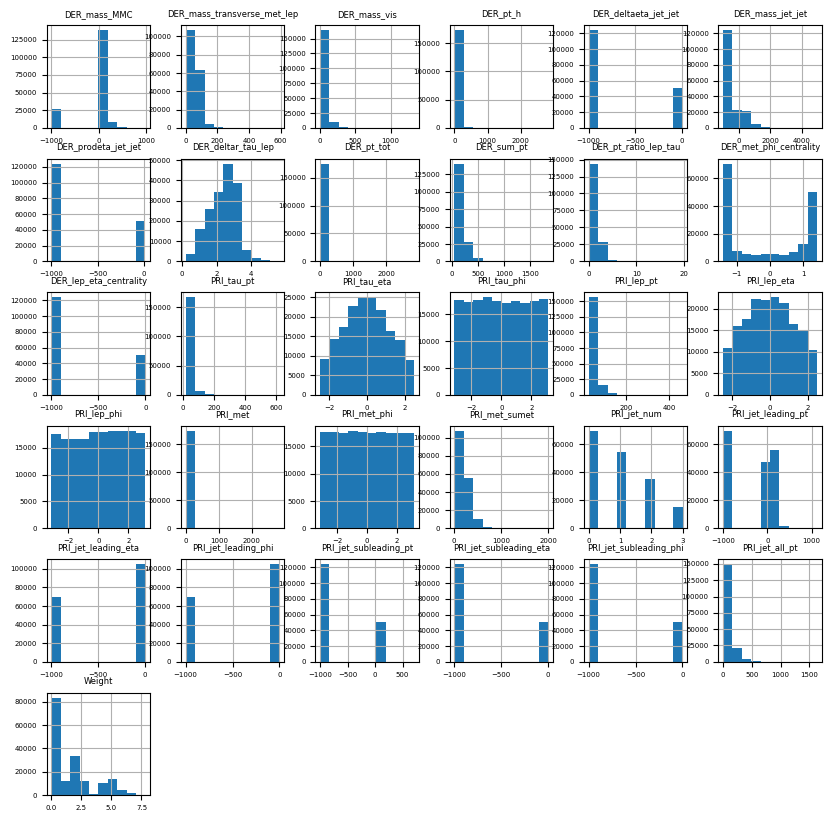

In [18]:
# identify features that basically only have two extreme values
#this might distort the classification because one extreme value might just be associated with one label
sample = higgs.sample(1000, random_state=42)
#plt.rcParams['font.size'] = 5
higgs.hist(figsize=(10, 10))
#pyplot.yscale('log')
plt.show()

In [19]:
# possibly problematic columns
higg_columns_problem = ['DER_mass_MMC',
'DER_deltaeta_jet_jet',
'DER_mass_jet_jet',
'DER_prodeta_jet_jet',
'DER_lep_eta_centrality',
'DER_met_phi_centrality',
'PRI_jet_leading_pt',
'PRI_jet_leading_eta',
'PRI_jet_num',
'PRI_jet_leading_phi',
'PRI_jet_subleading_pt',
'PRI_jet_subleading_eta',
'PRI_jet_subleading_phi',
'PRI_jet_all_pt',
'Weight']

In [15]:
# function to test how "balanced" these features are in terms of label distribution over them
# because these columns have different scales, use median to "divide" values
def test_balancedness(data, columns):
  for column in columns:
    selection = df_higgs[[column, 'Label']].copy()
    print(column)
    print(selection[selection[column] >= selection[column].median()].groupby('Label').size())

In [16]:
test_balancedness(df_higgs,higg_columns_problem)

DER_mass_MMC
Label
b    42076
s    45425
dtype: int64
DER_deltaeta_jet_jet
Label
b    115214
s     59786
dtype: int64
DER_mass_jet_jet
Label
b    115214
s     59786
dtype: int64
DER_prodeta_jet_jet
Label
b    115214
s     59786
dtype: int64
DER_lep_eta_centrality
Label
b    115214
s     59786
dtype: int64
DER_met_phi_centrality
Label
b    47341
s    40168
dtype: int64
PRI_jet_leading_pt
Label
b    50227
s    37273
dtype: int64
PRI_jet_leading_eta
Label
b    54464
s    33045
dtype: int64
PRI_jet_num
Label
b    63019
s    42077
dtype: int64
PRI_jet_leading_phi
Label
b    52513
s    34990
dtype: int64
PRI_jet_subleading_pt
Label
b    115214
s     59786
dtype: int64
PRI_jet_subleading_eta
Label
b    115214
s     59786
dtype: int64
PRI_jet_subleading_phi
Label
b    115214
s     59786
dtype: int64
PRI_jet_all_pt
Label
b    50173
s    37328
dtype: int64
Weight
Label
b    87500
dtype: int64


In [20]:
# identified coluns imbalanced (no hard criteria, just eye measure)
imbalanced_columns = ['DER_deltaeta_jet_jet',
'DER_mass_jet_jet',
'DER_prodeta_jet_jet',
'DER_lep_eta_centrality',
'PRI_jet_subleading_pt',
'PRI_jet_subleading_eta',
'PRI_jet_subleading_phi',
'Weight']

In [21]:
#drop
higgs = higgs.drop(imbalanced_columns, axis=1)

In [ ]:
# PRI_jet_num is int, check distribution over labels
df_higgs.groupby('PRI_jet_num')['Label'].size()

PRI_jet_num
0    69904
1    54243
2    35399
3    15454
Name: Label, dtype: int64

In [22]:
# possibly imbalanced, so drop it for now
higgs = higgs.drop('PRI_jet_num', axis=1)

**For remaining columns check collinearity**

<ipython-input-23-6b23d5630011>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = higgs.corr()
<ipython-input-23-6b23d5630011>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<Axes: >

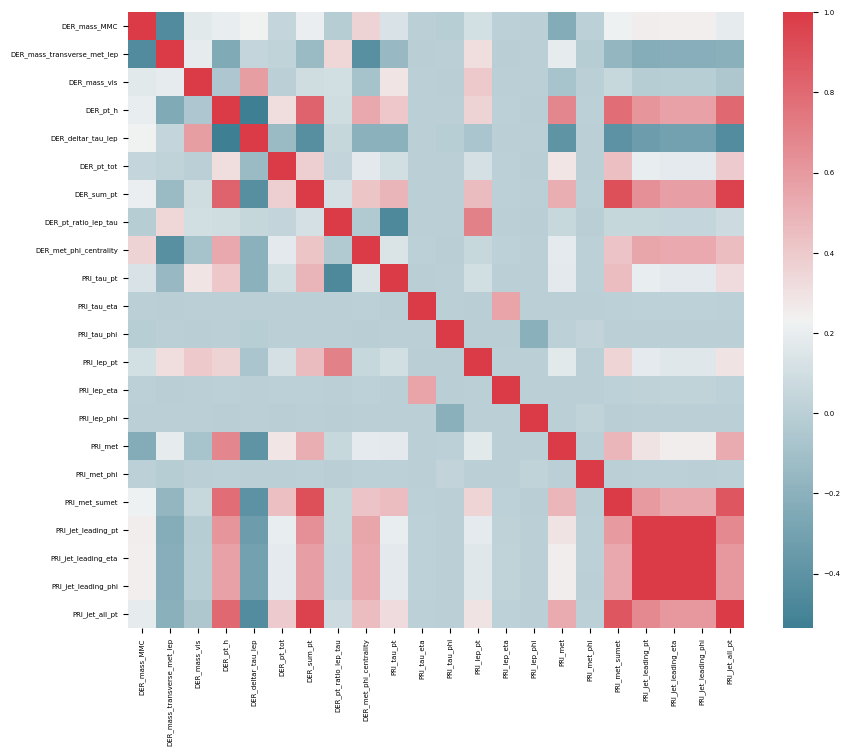

In [23]:
f, ax = plt.subplots(figsize=(10, 8))
corr = higgs.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [24]:
# all the PRI columsn have a high correlation
coll_columns1 = ['PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_all_pt']

In [25]:
higgs = higgs.drop(coll_columns1, axis=1)

<ipython-input-26-0ae367f9c52a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = higgs.corr()
<ipython-input-26-0ae367f9c52a>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<Axes: >

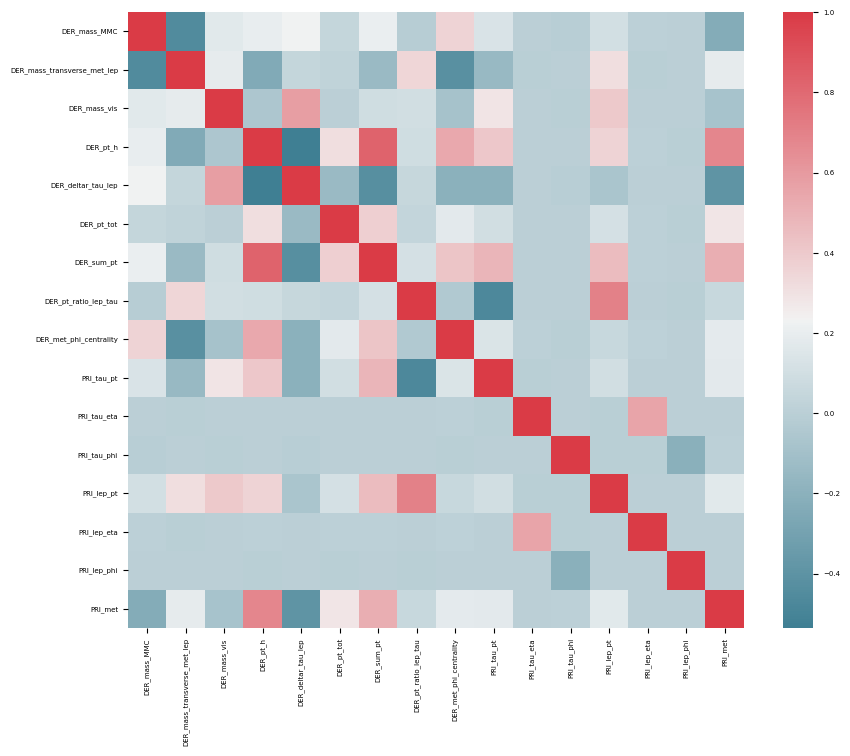

In [26]:
#check again
f, ax = plt.subplots(figsize=(10, 8))
corr = higgs.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Fine for now, maybe DER_pt_h could be dropped

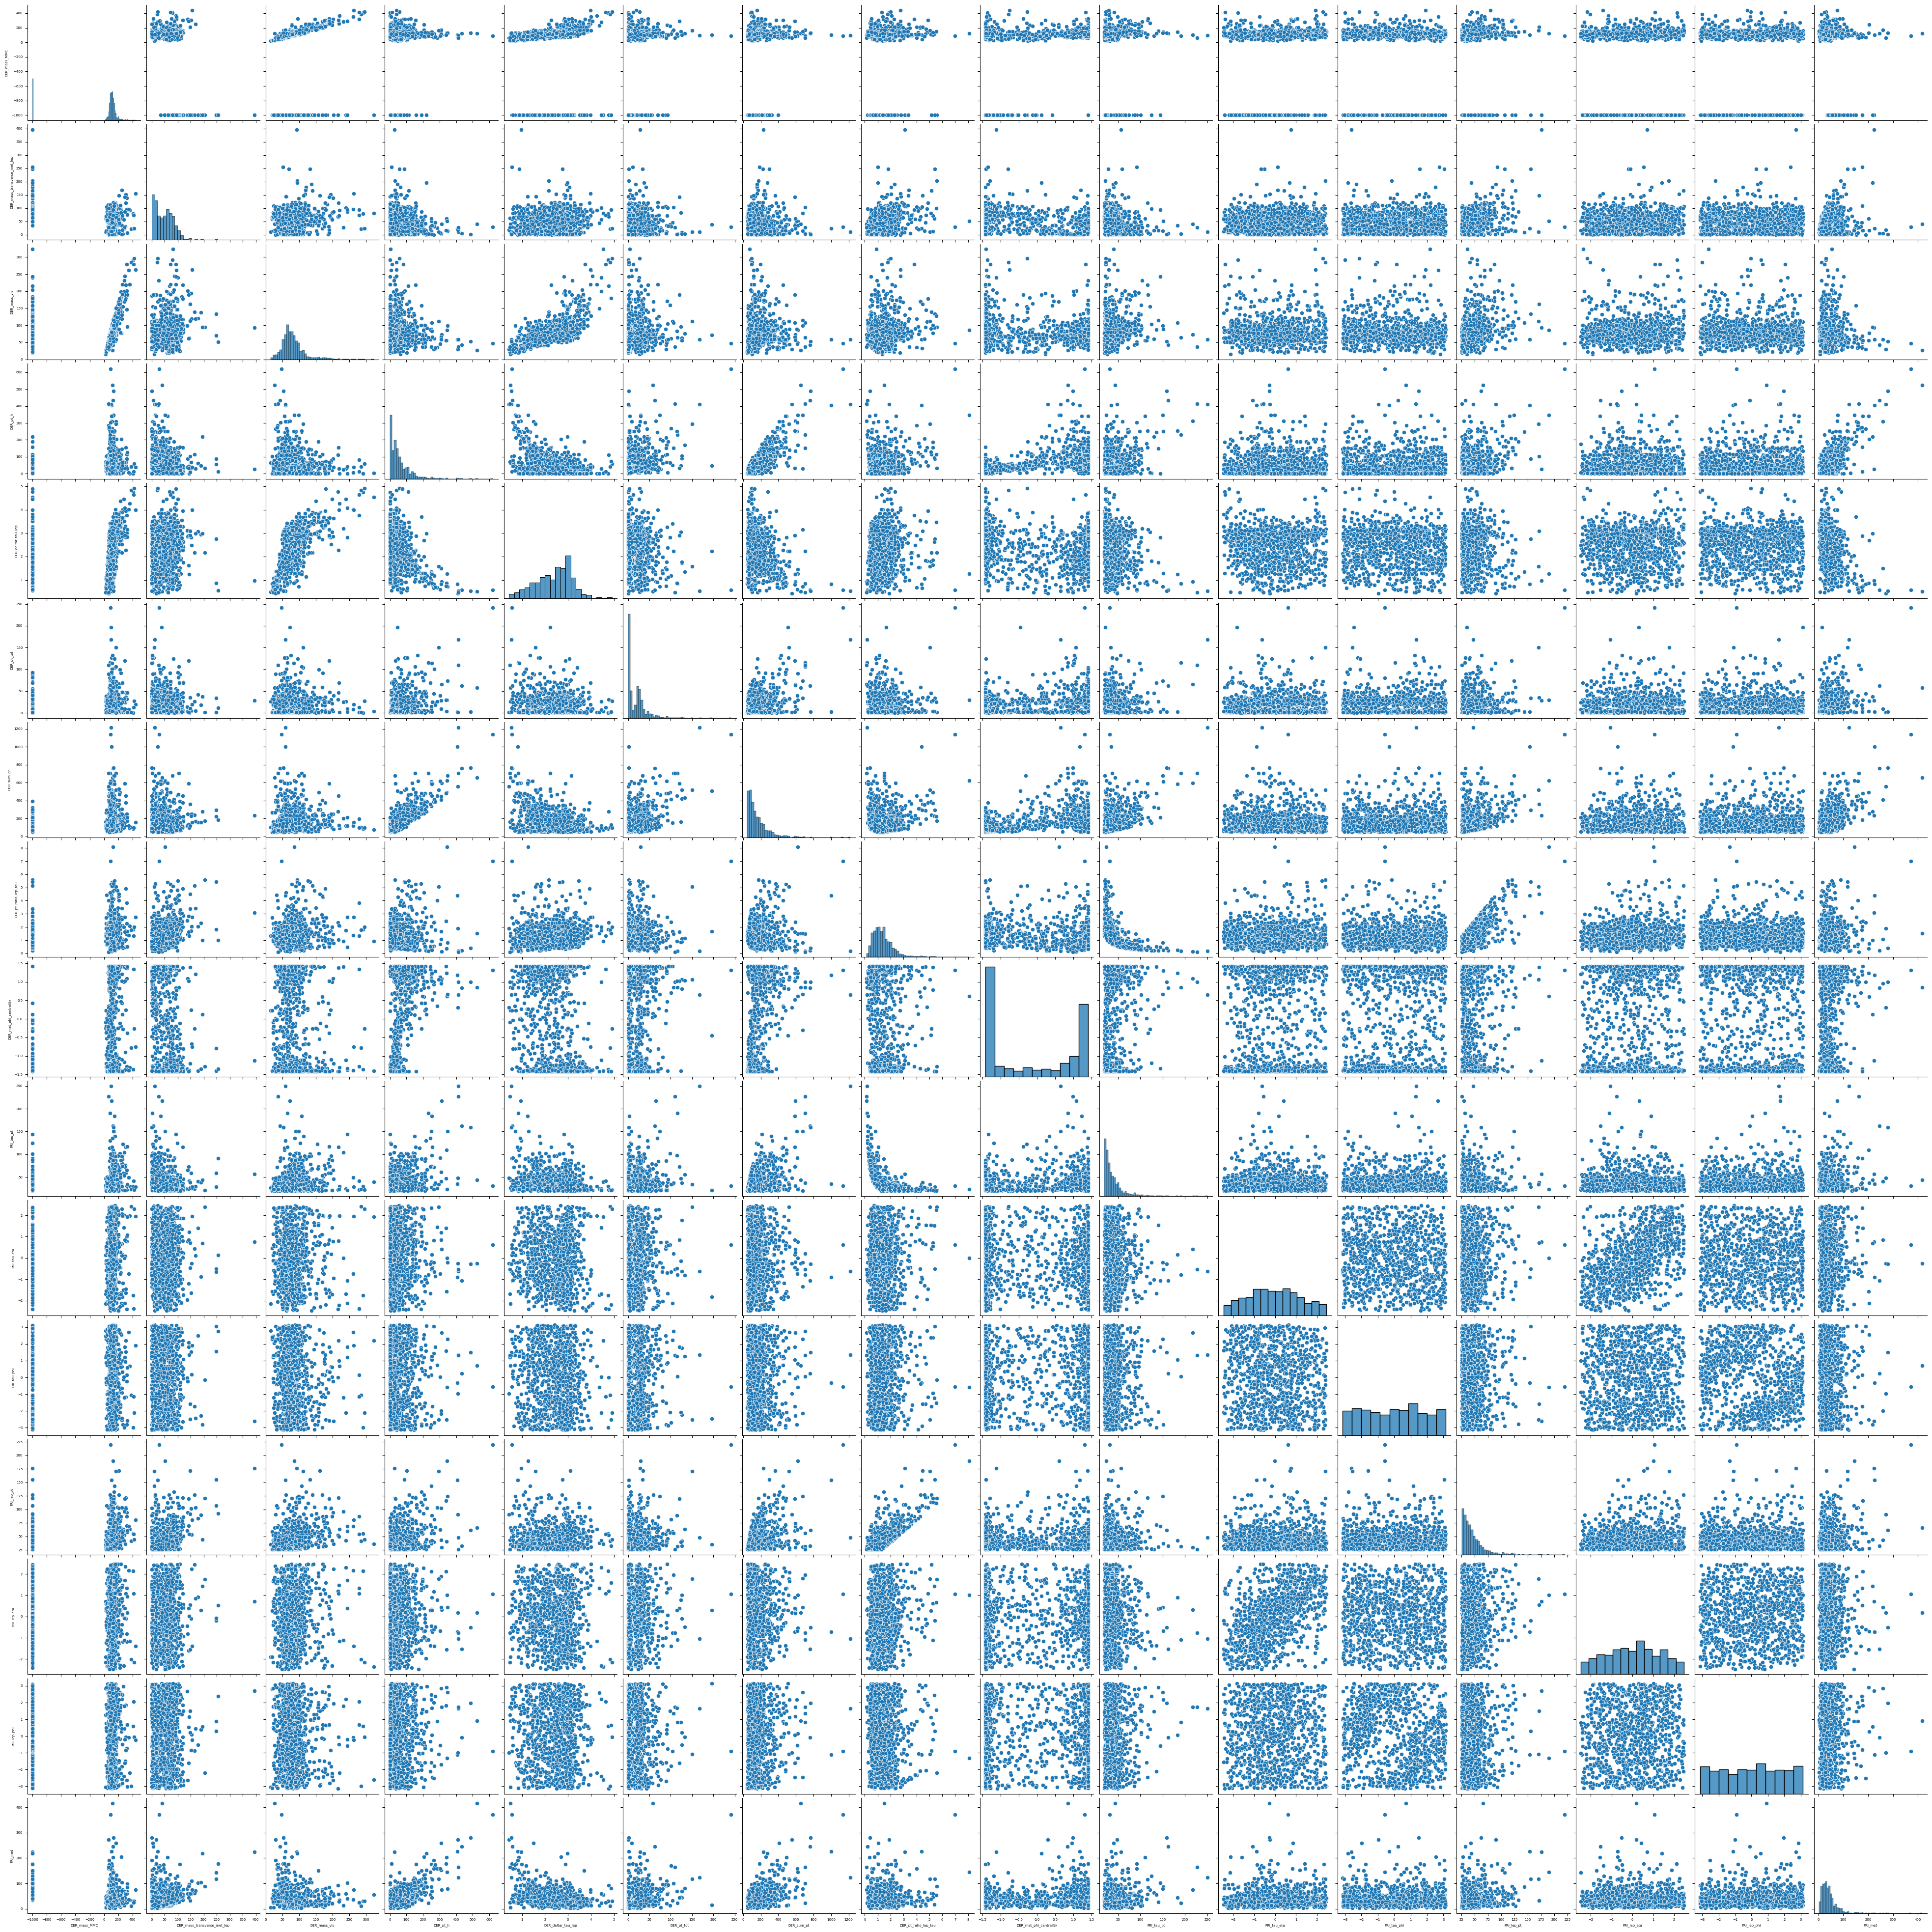

In [33]:
# check for other non-linear relationships between features
# take sample, otherwise too big to plot
higgs_sample = higgs.sample(1000, random_state=42)
sns.pairplot(higgs_sample)

There seems to be alot of structure left, but more or less it looks okay except for "DER_mass_MMC" (the distribution of labels seems however to be more or less equal). I left it in for the moment

In [35]:
# final list of columns to drop
higgs_drop = ['EventId',
              'DER_deltaeta_jet_jet',
              'DER_mass_jet_jet',
              'DER_prodeta_jet_jet',
              'DER_lep_eta_centrality',
              'PRI_jet_subleading_pt',
              'PRI_jet_subleading_eta',
              'PRI_jet_subleading_phi',
              'Weight',
              'PRI_jet_num',
              'PRI_met_phi',
              'PRI_met_sumet',
              'PRI_jet_leading_pt',
              'PRI_jet_leading_eta',
              'PRI_jet_leading_phi',
              'PRI_jet_all_pt']

### Prepare data sets

In [65]:
def clean_higgs_data(data, drop_columns, train=True):
  print("Inital dimensions:", data.values.shape)
  if train:
    # replace labels with int values (because final submission needs to be 0, 1)
    data['Label'] = data['Label'].replace(('b','s'), (0,1))
  #drop columns
  data = data.drop(drop_columns, axis=1)
  print("New dimensions:", data.values.shape)
  return data

In [66]:
clean_higgs_data(df_higgs, higgs_drop)

Inital dimensions: (175000, 33)
New dimensions: (175000, 17)


DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0            136.372                       32.142        95.158    24.012   
1            123.147                       73.967        73.065     1.951   
2            114.196                       77.282        84.580     1.398   
3            113.938                       37.713        78.068    73.541   
4           -999.000                       82.024        55.707    15.350   
...              ...                          ...           ...       ...   
174995       121.911                       56.518        65.629    46.272   
174996      -999.000                       65.925        78.781     3.387   
174997       134.949                       43.702        97.972    28.240   
174998       126.725                       23.997        87.432   283.336   
174999        79.885                       58.412        56.758    14.061   

        DER_deltar_tau_lep  DER_pt_tot  DER_sum_pt  DER_pt_ratio_lep_tau  \
0                    2.650      24.012      81.013                 0.499   
1                    3.181       1.951      73.968                 2.106   
2                    2.808       1.398      86.994                 1.752   
3                    2.062       2.179     176.908                 0.670   
4                    1.943      15.350      62.787                 1.461   
...                    ...         ...         ...                   ...   
174995               3.068       6.385      98.652                 0.821   
174996               2.493       3.387      55.956                 1.038   
174997               3.443      28.240      77.985                 0.703   
174998               0.872     107.851     621.442                 0.367   
174999               2.512      16.746     276.699                 1.144   

        DER_met_phi_centrality  PRI_tau_pt  PRI_tau_eta  PRI_tau_phi  \
0                       -0.976      54.044       -0.030       -1.466   
1                        1.064      23.812        1.477       -2.197   
2                       -1.354      31.613        0.032       -1.295   
3                        1.380      55.592       -1.102       -1.189   
4                       -1.414      25.509       -1.108        2.158   
...                        ...         ...          ...          ...   
174995                   1.404      32.261       -0.537        0.664   
174996                  -1.409      27.453       -0.378        1.416   
174997                  -1.414      45.793       -0.564        1.563   
174998                   1.399     170.813        0.852        0.785   
174999                  -1.398      27.652        1.917       -0.964   

        PRI_lep_pt  PRI_lep_eta  PRI_lep_phi  PRI_met  Label  
0           26.969       -1.637        0.641   40.636      0  
1           50.156        0.805        0.977   27.279      0  
2           55.381        0.498        2.219   27.909      0  
3           37.219       -1.132        0.873   23.319      1  
4           37.278       -0.121       -2.452   54.284      0  
...            ...          ...          ...      ...    ...  
174995      26.489        0.468       -2.720   37.187      1  
174996      28.503        1.739        2.731   41.678      0  
174997      32.192       -2.016       -1.599   16.124      1  
174998      62.739        0.817        1.656   68.778      1  
174999      31.622        1.624        1.531   32.000      0  

[175000 rows x 17 columns]


## Evaluate different classifiers

In [45]:
def get_features_labels_higgs(data):
  X = data.drop("Label", axis=1).values
  y = data.loc[:, 'Label'].values
  return [X, y]

In [54]:
X, y = get_features_labels_higgs(clean_higgs_data(df_higgs, higgs_drop))

Inital dimensions: (175000, 33)
New dimensions: (175000, 17)


In [59]:
names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Logistic Regression"
]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=10, random_state=42),
    RandomForestClassifier(
        max_depth=10, n_estimators=100, max_features=1, random_state=42
    ),
    AdaBoostClassifier(random_state=42),
    LogisticRegression(random_state=42)
]

def test_classifiers_higgs(x, y, names_classifiers, classifiers):
  scores = []
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  for name, clf in zip(names_classifiers, classifiers):
    print("Classifer" + name)
    results = {"model": name, "parameters": clf.get_params()}
    print("Train ")
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    print("Test")
    acc = clf.score(X_test, y_test)
    results.update({"score": acc})
    print("Done")
    scores.append(results)
  print(scores)
  return scores

In [60]:
test_classifiers_higgs(X, y, names, classifiers)

ClassiferNearest Neighbors
Train 
Test
Done
ClassiferDecision Tree
Train 
Test
Done
ClassiferRandom Forest
Train 
Test
Done
ClassiferAdaBoost
Train 
Test
Done
ClassiferLogistic Regression
Train 
Test
Done
[{'model': 'Nearest Neighbors', 'parameters': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}, 'score': 0.7705714285714286}, {'model': 'Decision Tree', 'parameters': {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}, 'score': 0.8182571428571429}, {'model': 'Random Forest', 'parameters': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 1, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decre

[{'model': 'Nearest Neighbors',
  'parameters': {'algorithm': 'auto',
   'leaf_size': 30,
   'metric': 'minkowski',
   'metric_params': None,
   'n_jobs': None,
   'n_neighbors': 3,
   'p': 2,
   'weights': 'uniform'},
  'score': 0.7705714285714286},
 {'model': 'Decision Tree',
  'parameters': {'ccp_alpha': 0.0,
   'class_weight': None,
   'criterion': 'gini',
   'max_depth': 10,
   'max_features': None,
   'max_leaf_nodes': None,
   'min_impurity_decrease': 0.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'min_weight_fraction_leaf': 0.0,
   'random_state': 42,
   'splitter': 'best'},
  'score': 0.8182571428571429},
 {'model': 'Random Forest',
  'parameters': {'bootstrap': True,
   'ccp_alpha': 0.0,
   'class_weight': None,
   'criterion': 'gini',
   'max_depth': 10,
   'max_features': 1,
   'max_leaf_nodes': None,
   'max_samples': None,
   'min_impurity_decrease': 0.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'min_weight_fraction_leaf': 0.0,
   'n_estimator

## Hyperparameter Tuning

In [62]:
def test_classifier_higgs(x, y, classifier):
  result = {"parameters": classifier.get_params()}
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  print("Train ")
  classifier = make_pipeline(StandardScaler(), classifier)
  classifier.fit(X_train, y_train)
  print("Test")
  acc = classifier.score(X_test, y_test)
  result.update({"score": acc})
  print("Done")
  print(result)
  return result

In [63]:
clf = RandomForestClassifier(
        max_depth=10, n_estimators=100, max_features=1, random_state=42
    )
test_classifier_higgs(X, y, clf)

Train 
Test
Done
{'parameters': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 1, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}, 'score': 0.8183714285714285}


{'parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'max_features': 1,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 100,
  'n_jobs': None,
  'oob_score': False,
  'random_state': 42,
  'verbose': 0,
  'warm_start': False},
 'score': 0.8183714285714285}

# Make predictions

In [69]:
def make_prediction(train_set, drop_columns,  test_set, classifier, test_submission):
  train = clean_higgs_data(train_set, drop_columns)
  test = clean_higgs_data(test_set, drop_columns, train=False)
  X_test = test.values
  X,y = get_features_labels_higgs(train)
  print("train")
  classifier = make_pipeline(StandardScaler(), classifier)
  classifier.fit(X, y)
  print("predict")
  y_pred = classifier.predict(X_test)
  test_submission['pred'] = y_pred
  test_submission = test_submission.drop('Prediction', axis=1)
  test_submission = test_submission.rename(columns={'pred': 'Prediction'})
  return test_submission

In [71]:
df_higgs = pd.read_csv("/content/drive/MyDrive/aml/data/higgs_train.csv")
higgs_drop = ['EventId',
              'DER_deltaeta_jet_jet',
              'DER_mass_jet_jet',
              'DER_prodeta_jet_jet',
              'DER_lep_eta_centrality',
              'PRI_jet_subleading_pt',
              'PRI_jet_subleading_eta',
              'PRI_jet_subleading_phi',
              'Weight',
              'PRI_jet_num',
              'PRI_met_phi',
              'PRI_met_sumet',
              'PRI_jet_leading_pt',
              'PRI_jet_leading_eta',
              'PRI_jet_leading_phi',
              'PRI_jet_all_pt']
higgs_test = pd.read_csv("/content/drive/MyDrive/aml/data/higgs_test.csv")
clf = RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1, random_state=42)
submission_higgs = pd.read_csv("/content/drive/MyDrive/aml/data/higgs_test_submission.csv")


submission = make_prediction(df_higgs, higgs_drop, higgs_test, clf, submission_higgs)

Inital dimensions: (175000, 33)
New dimensions: (175000, 17)
Inital dimensions: (75000, 32)
New dimensions: (75000, 16)
train
predict
